# Cargue y preentrenamiento de datos

In [1]:
import os
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

def sobremuestrear_y_seleccionar(imagenes, etiquetas, n_samples=1000):
    unique_labels = list(set(etiquetas))
    imagenes_sobremuestreadas = []
    etiquetas_sobremuestreadas = []

    for etiqueta in unique_labels:
        imagenes_de_etiqueta = [img for img, lbl in zip(imagenes, etiquetas) if lbl == etiqueta]
        
        if len(imagenes_de_etiqueta) < n_samples:
            # Sobremuestrear
            falta = n_samples - len(imagenes_de_etiqueta)
            imagenes_de_etiqueta.extend(random.choices(imagenes_de_etiqueta, k=falta))
        
        # Seleccionar 1000 imágenes aleatorias
        imagenes_de_etiqueta = random.sample(imagenes_de_etiqueta, n_samples)
        
        imagenes_sobremuestreadas.extend(imagenes_de_etiqueta)
        etiquetas_sobremuestreadas.extend([etiqueta] * n_samples)

    return imagenes_sobremuestreadas, etiquetas_sobremuestreadas


In [2]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/MLRSNet'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)
print(tamanios_por_etiqueta)

# Sobremuestrear y seleccionar
imagenes_sobremuestreadas, etiquetas_sobremuestreadas = sobremuestrear_y_seleccionar(imagenes, etiquetas, n_samples=1000)


{'baseball_diamond': {(256, 256)}, 'basketball_court': {(256, 256)}, 'golf_course': {(256, 256)}, 'ground_track_field': {(256, 256)}, 'park': {(256, 256)}, 'stadium': {(256, 256)}, 'tennis_court': {(256, 256)}}


In [3]:
# Redimensionar las imágenes si es necesario
if not verificar_tamanio(imagenes_sobremuestreadas):
    nuevo_tamanio = (256, 256)  # Ejemplo de nuevo tamaño
    imagenes_sobremuestreadas = redimensionar_imagenes(imagenes_sobremuestreadas, nuevo_tamanio)

# Normalizar las imágenes
imagenes_normalizadas = normalizar_imagenes(imagenes_sobremuestreadas)

# Listo para usar las imágenes normalizadas y etiquetas para tu modelo
print(f'Total de imágenes después de sobremuestreo y selección: {len(imagenes_normalizadas)}')
print(f'Total de etiquetas después de sobremuestreo y selección: {len(etiquetas_sobremuestreadas)}')

Total de imágenes después de sobremuestreo y selección: 7000
Total de etiquetas después de sobremuestreo y selección: 7000


In [4]:
# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3, 'park': 4,'stadium': 5,'tennis_court': 6}
etiquetas_codificadas = np.array([codificacion[etiquetas_sobremuestreadas] for etiquetas_sobremuestreadas in etiquetas_sobremuestreadas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 797, 1: 817, 2: 822, 3: 776, 4: 814, 5: 789, 6: 785}


In [5]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 822, 1: 822, 2: 822, 3: 822, 4: 822, 5: 822, 6: 822}


In [6]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 5600
Número de ejemplos de entrenamiento después del balanceo: 5754
Número de ejemplos de prueba: 1400


# Entrenamiento modelo customizado

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(7, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,935 (60.14 MB)

 Trainable params: 15,764,935 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 167s 916ms/step - accuracy: 0.4188 - loss: 1.7080 - val_accuracy: 0.7706 - val_loss: 0.6587
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - accuracy: 0.7950 - loss: 0.6107 - val_accuracy: 0.8891 - val_loss: 0.3567
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 102s 565ms/step - accuracy: 0.9175 - loss: 0.2661 - val_accuracy: 0.9755 - val_loss: 0.1001
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 101s 564ms/step - accuracy: 0.9814 - loss: 0.0829 - val_accuracy: 0.9939 - val_loss: 0.0317
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 102s 566ms/step - accuracy: 0.9947 - loss: 0.0273 - val_accuracy: 0.9998 - val_loss: 0.0051
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 99s 552ms/step - accuracy: 0.9977 - loss: 0.0121 - val_accuracy: 0.9873 - val_loss: 0.0428
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 557ms/step - accuracy: 0.9946 - loss: 0.0202 - val_accuracy: 0.9981 - val_loss: 0.0111
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 556ms/step - accuracy: 0.9971 - 

In [9]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7858 - loss: 1.2728


In [10]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']))

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step
Precision: 0.8060625394261172
Recall: 0.8035714285714286
F1 Score: 0.803048188212662
Accuracy: 0.8035714285714286
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.88      0.90      0.89       203
  basketball_court       0.86      0.72      0.78       224
       golf_course       0.84      0.84      0.84       186
ground_track_field       0.80      0.85      0.82       178
              park       0.74      0.84      0.79       183
           stadium       0.77      0.72      0.74       215
      tennis_court       0.75      0.79      0.77       211

          accuracy                           0.80      1400
         macro avg       0.81      0.81      0.80      1400
      weighted avg       0.81      0.80      0.80      1400



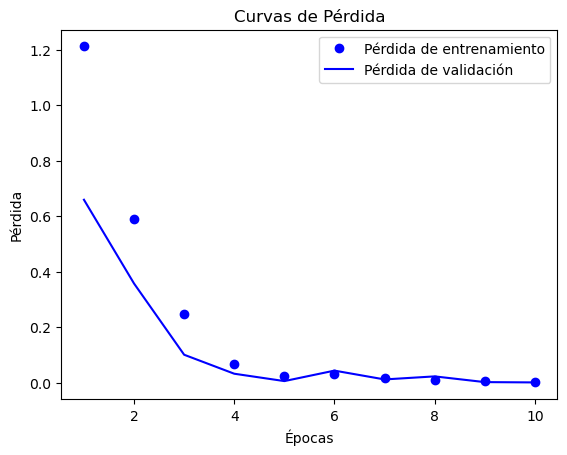

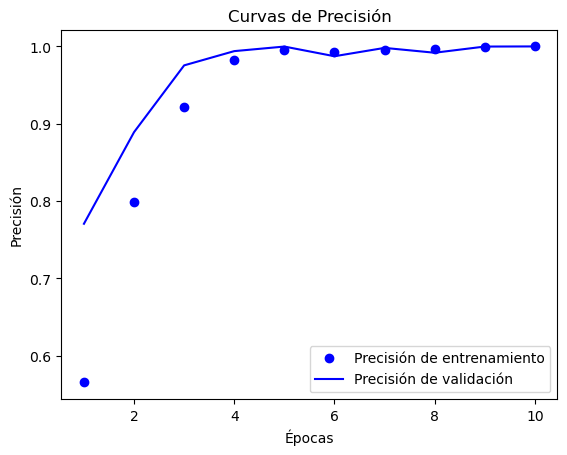

In [11]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [78]:
# Abrir la imagen
#imagen = Image.open('C:/Users/nicol/Desktop/Datasets/Dota2/part2-001/images/P1105.png')

# Redimensionar la imagen a 256x256
#imagen_redimensionada = imagen.resize((256, 256))

# Convertir la imagen redimensionada a un arreglo (matriz) y normalizarla
#imagen_arreglo = np.array(imagen_redimensionada) / 255.0

# Agregar una dimensión adicional para representar el lote
#imagen_arreglo = np.expand_dims(imagen_arreglo, axis=0)

In [79]:
# Realizar predicciones
#predicciones = modelo.predict(imagen_arreglo)

# Interpretar las predicciones
#clase_predicha = np.argmax(predicciones, axis=1)

# Visualizar resultados (opcional)
#print("Predicciones:", clase_predicha)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicciones: [5]


# Entrenamiento con VGG16

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  



In [13]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.3975 - loss: 1.9423 - val_accuracy: 0.7986 - val_loss: 0.7521
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.5946 - loss: 1.0381 - val_accuracy: 0.8257 - val_loss: 0.5513
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.6543 - loss: 0.8763 - val_accuracy: 0.8079 - val_loss: 0.6067
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.7048 - loss: 0.7301 - val_accuracy: 0.8571 - val_loss: 0.4262
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.7476 - loss: 0.6366 - val_accuracy: 0.8579 - val_loss: 0.4240
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.7600 - loss: 0.5895 - val_accuracy: 0.8729 - val_loss: 0.4195
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.7808 - loss: 0.5433 - val_accuracy: 0.8664 - val_loss: 0.4035
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.7937 - loss: 0.5051 - val_accu

In [14]:

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']))

44/44 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step
Precision: 0.8772349135468669
Recall: 0.8728571428571429
F1 Score: 0.8728435829713515
Accuracy: 0.8728571428571429
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.91      0.96      0.93       203
  basketball_court       0.79      0.86      0.83       224
       golf_course       0.88      0.90      0.89       186
ground_track_field       0.79      0.90      0.84       178
              park       0.92      0.85      0.88       183
           stadium       0.94      0.88      0.91       215
      tennis_court       0.91      0.76      0.83       211

          accuracy                           0.87      1400
         macro avg       0.88      0.87      0.87      1400
      weighted avg       0.88      0.87      0.87      1400



# Entrenamiento con Resnet18

In [23]:
from tensorflow.keras.applications import ResNet50

# Cargar el modelo ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x) 


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [26]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2279 - loss: 1.7774 - val_accuracy: 0.2308 - val_loss: 1.7726
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2072 - loss: 1.7782 - val_accuracy: 0.2308 - val_loss: 1.7706
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2247 - loss: 1.7735 - val_accuracy: 0.2308 - val_loss: 1.7683
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2197 - loss: 1.7699 - val_accuracy: 0.2308 - val_loss: 1.7664
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2136 - loss: 1.7736 - val_accuracy: 0.2308 - val_loss: 1.7646
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2176 - loss: 1.7745 - val_accuracy: 0.2308 - val_loss: 1.7628
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2154 - loss: 1.7707 - val_accuracy: 0.2308 - val_loss: 1.7614
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2261 - loss: 1.7724 - val_accuracy: 0.2308 - val_loss:

In [27]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Precision: 0.03489916676729864
Recall: 0.18681318681318682
F1 Score: 0.05881155881155881
Accuracy: 0.18681318681318682
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       0.00      0.00      0.00        26
  footballField       0.00      0.00      0.00         8
     golfcourse       0.19      1.00      0.31        17
           Park       0.00      0.00      0.00        11
           Pond       0.00      0.00      0.00         8
    tenniscourt       0.00      0.00      0.00        21

       accuracy                           0.19        91
      macro avg       0.03      0.17      0.05        91
   weighted avg       0.03      0.19      0.06        91



C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packag

# Modelo Preentrenado Xception con ImageNet

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  



In [18]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.4415 - loss: 3.4357 - val_accuracy: 0.7550 - val_loss: 0.8057
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 584s 3s/step - accuracy: 0.6001 - loss: 1.0885 - val_accuracy: 0.8221 - val_loss: 0.5474
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.6415 - loss: 0.9733 - val_accuracy: 0.8271 - val_loss: 0.4736
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.6756 - loss: 0.8142 - val_accuracy: 0.8521 - val_loss: 0.4522
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.6998 - loss: 0.7818 - val_accuracy: 0.8500 - val_loss: 0.4883
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.7150 - loss: 0.6969 - val_accuracy: 0.8629 - val_loss: 0.4621
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.7090 - loss: 0.7147 - val_accuracy: 0.8529 - val_loss: 0.4692
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.7313 - loss: 0.6660 - val_accu

In [19]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']))

44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Precision: 0.8606217151311255
Recall: 0.8557142857142858
F1 Score: 0.8544375171713705
Accuracy: 0.8557142857142858
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.92      0.98      0.95       224
  basketball_court       0.78      0.77      0.78       203
       golf_course       0.96      0.84      0.90       211
ground_track_field       0.90      0.70      0.79       215
              park       0.80      0.94      0.86       186
           stadium       0.84      0.85      0.85       178
      tennis_court       0.80      0.91      0.85       183

          accuracy                           0.86      1400
         macro avg       0.86      0.86      0.85      1400
      weighted avg       0.86      0.86      0.85      1400



# Entrenamiento con MobileNet Preentrenado con Imagenet

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)

model = model.to(device)


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


Epoch 1, Loss: 0.5856794616414441
Epoch 2, Loss: 0.3406919049306048
Epoch 3, Loss: 0.28446021847840813
Epoch 4, Loss: 0.2191295322134263
Epoch 5, Loss: 0.20121564865888406
Epoch 6, Loss: 0.17225662732703817
Epoch 7, Loss: 0.16175009704505403
Epoch 8, Loss: 0.08944819430277372
Epoch 9, Loss: 0.12167588311454489
Epoch 10, Loss: 0.1430812650618868


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 90.50000%
Precision: 0.90529
Recall: 0.90500
F1 Score: 0.90488


In [13]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/MLRSNet_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [16]:
# Número de épocas
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 84.64286%
Precision: 0.84848
Recall: 0.84643
F1 Score: 0.84704
